# Simulation of Lorenz96 model with Runge Kutta 4-th order method and generation of observation for the filtering part

In [1]:
# -*- coding: utf-8 -*-
"""
This code is based on the paper PyDA: A Hands-On Introduction to Dynamical Data Assimilation with Python. 
"""
#%% Import libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.integrate import simps
import pyfftw

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import pandas as pd
import time as clck
import os

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 14}    
plt.rc('font', **font)

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

#%%
def rhs_dy_dt(J,u,y,fr,h,c,b,dt):
    v = np.zeros((ne+2,J+4))
    
    v[1:ne+1,2:J+2] = y[:,:]
    
    v[0,:] = v[ne,:]
    v[ne+1,:] = v[1,:]
    
    v[1:ne+2,1] = v[0:ne+1,J+1]
    v[1:ne+2,0] = v[0:ne+1,J]
    v[0:ne+1,J+2] = v[1:ne+2,2]
    v[0:ne+1,J+3] = v[1:ne+2,3]
    
    x = np.reshape(u,[-1,1])
    r = np.zeros((ne,J))
    
#    for i in range(ne):
#        for j in range(2,J+2):
#            r[i,j-2] = -b*c*v[i,j+1]*(v[i,j+2] - v[i,j+1]) - c*v[i,j] + h*c*x[i]/J
            
    r = -b*c*v[1:ne+1,3:J+3]*(v[1:ne+1,4:J+4] - v[1:ne+1,1:J+1]) - c*v[1:ne+1,2:J+2] + h*c*x/b
    
    return r*dt    
    
def rhs_dx_dt(ne,u,y,fr,h,c,dt):
    v = np.zeros(ne+3)
    v[2:ne+2] = u
    v[1] = v[ne+1]
    v[0] = v[ne]
    v[ne+2] = v[2]
    
    r = np.zeros(ne)
    
#    for i in range(2,ne+2):
#        r[i-2] = v[i-1]*(v[i+1] - v[i-2]) - v[i] + fr
    
    ysum = np.sum(y,axis=1)
    r = -v[1:ne+1]*(v[0:ne] - v[3:ne+3]) - v[2:ne+2] + fr - (h*c/b)*ysum
    
    return r*dt
    
    
def rk4c(ne,J,u,y,fr,h,c,b,dt):
    k1x = rhs_dx_dt(ne,u,y,fr,h,c,dt)
    k1y = rhs_dy_dt(J,u,y,fr,h,c,b,dt)
    
    k2x = rhs_dx_dt(ne,u+0.5*k1x,y+0.5*k1y,fr,h,c,dt)
    k2y = rhs_dy_dt(J,u+0.5*k1x,y+0.5*k1y,fr,h,c,b,dt)
    
    k3x = rhs_dx_dt(ne,u+0.5*k2x,y+0.5*k2y,fr,h,c,dt)
    k3y = rhs_dy_dt(J,u+0.5*k2x,y+0.5*k2y,fr,h,c,b,dt)
    
    k4x = rhs_dx_dt(ne,u+0.5*k3x,y+0.5*k3y,fr,h,c,dt)
    k4y = rhs_dy_dt(J,u+0.5*k3x,y+0.5*k3y,fr,h,c,b,dt)
    
    un = u + (k1x + 2.0*(k2x + k3x) + k4x)/6.0
    yn = y + (k1y + 2.0*(k2y + k3y) + k4y)/6.0
    
    return un,yn

def rk4uc(ne,J,u,y,fr,h,c,b,dt):
    k1x = rhs_dx_dt(ne,u,y,fr,h,c,dt)
    k2x = rhs_dx_dt(ne,u+0.5*k1x,y,fr,h,c,dt)
    k3x = rhs_dx_dt(ne,u+0.5*k2x,y,fr,h,c,dt)
    k4x = rhs_dx_dt(ne,u+0.5*k3x,y,fr,h,c,dt)
    
    # update y with an unupdated x
    k1y = rhs_dy_dt(J,u,y,fr,h,c,b,dt)    
    k2y = rhs_dy_dt(J,u,y+0.5*k1y,fr,h,c,b,dt)
    k3y = rhs_dy_dt(J,u,y+0.5*k2y,fr,h,c,b,dt)
    k4y = rhs_dy_dt(J,u,y+0.5*k3y,fr,h,c,b,dt)
    
    un = u + (k1x + 2.0*(k2x + k3x) + k4x)/6.0
    yn = y + (k1y + 2.0*(k2y + k3y) + k4y)/6.0
    
    return un,yn



#%% Main program:
ne = 40
J = 10
fr = 10.0
c = 10.0
b = 10.0
h = 1.0

fact = 0.1
std = 1.0

dt = 0.001
tmax = 20.0
tinit = 5.0
ns = int(tinit/dt)
nt = int(tmax/dt)

nf = 10         # frequency of observation
nb = int(nt/nf) # number of observation time
oib = [nf*k for k in range(nb+1)]

u = np.zeros(ne)
utrue = np.zeros((ne,nt+1))
uinit = np.zeros((ne,ns+1))
ysuminit = np.zeros((ne,ns+1))
ysum = np.zeros((ne,nt+1))
yall = np.zeros((ne,J,nt+1))

ti = np.linspace(-tinit,0,ns+1)
t = np.linspace(0,tmax,nt+1)
tobs = np.linspace(0,tmax,nb+1)
x = np.linspace(1,ne,ne)

X,T = np.meshgrid(x,t,indexing='ij')
Xi,Ti = np.meshgrid(x,ti,indexing='ij')

#%%
#-----------------------------------------------------------------------------#
# generate true solution trajectory
#-----------------------------------------------------------------------------#
u[:] = fr
u[int(ne/2)-1] = fr + 0.01
#u = 2*fr*np.random.random_sample(ne) - fr
uinit[:,0] = u

y = 2*fact*fr*np.random.random_sample((ne, J)) - fact*fr 

#%%

# generate initial condition at t = 0
for k in range(1,ns+1):
    un, yn = rk4uc(ne,J,u,y,fr,h,c,b,dt)
    uinit[:,k] = un
    ysuminit[:,k] = np.sum(yn,axis=1)
    u = np.copy(un)
    y = np.copy(yn)

# assign inital condition
u = uinit[:,-1]
utrue[:,0] = uinit[:,-1]
ysum[:,0] = ysuminit[:,-1]
yall[:,:,0] = yn

#initX = np.load('./Lorenz-Online/data/initX.npy')
#initY = np.load('./Lorenz-Online/data/initY.npy')
#y = np.reshape(initY,[ne,J])

# generate true forward solution
for k in range(1,nt+1):
    un, yn = rk4uc(ne,J,u,y,fr,h,c,b,dt)
    utrue[:,k] = un
    ysum[:,k] = np.sum(yn,axis=1)
    yall[:,:,k] = yn
    u = np.copy(un)
    y = np.copy(yn)

np.savez('data_cyclic.npz',utrue=utrue,ysum=ysum,yall=yall)

/home/aydogdu/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


# Plotting graphs with model components

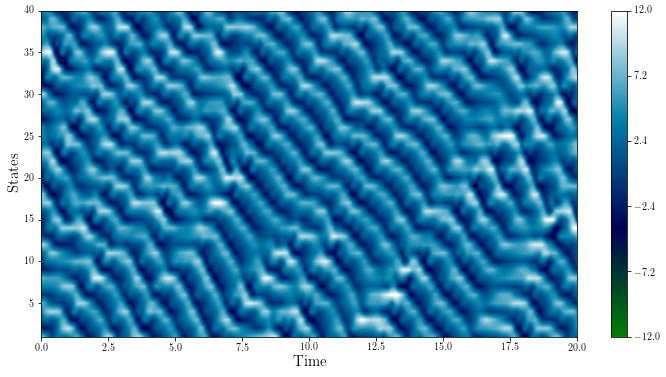

In [2]:
vmin = -12
vmax = 12
fig, ax = plt.subplots(1,1,figsize=(12,6))
cs = ax.contourf(T,X,utrue,40,cmap='ocean',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='ocean')
m.set_array(utrue)
m.set_clim(vmin, vmax)
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('States', fontsize=15)
fig.colorbar(m,ax=ax,ticks=np.linspace(vmin, vmax, 6))
#plt.savefig('Lorenz96_map.png')

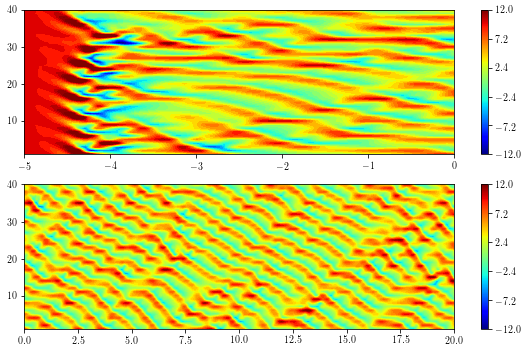

In [3]:
vmin = -12
vmax = 12
fig, ax = plt.subplots(2,1,figsize=(8,5))
cs = ax[0].contourf(Ti,Xi,uinit,40,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(uinit)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))

cs = ax[1].contourf(T,X,utrue,40,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(utrue)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))

fig.tight_layout()
plt.show()

# Plots for slow and fast components

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


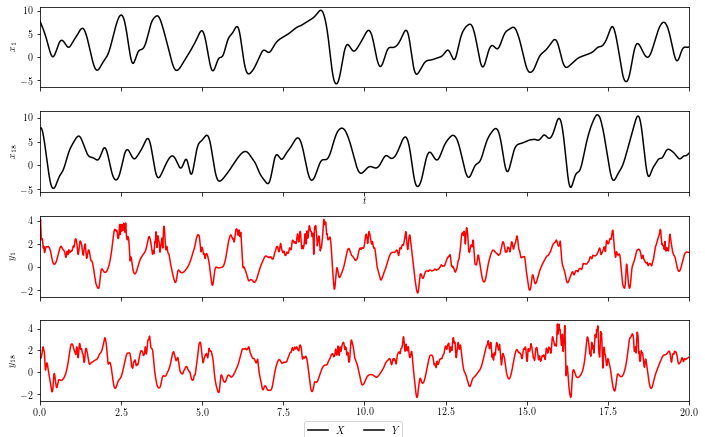

In [4]:
data = np.load('data_cyclic.npz')
yp = data['ysum']
fig, ax = plt.subplots(4,1,sharex=True,figsize=(10,6))

n = [0,17]
for i in range(2):
    ax[i].plot(t,utrue[n[i],:],'k-')
    ax[i+2].plot(t,ysum[n[i],:],'r-')
#    ax[i+2].plot(t,yp[n[i],:],'g-')
    ax[i].set_xlim([0,tmax])
    ax[i].set_ylabel(r'$x_{'+str(n[i]+1)+'}$')
    ax[i+2].set_ylabel(r'$y_{'+str(n[i]+1)+'}$')
    
ax[i].set_xlabel(r'$t$')
line_labels = ['$X$','$Y$']
plt.figlegend( line_labels,  loc = 'lower center', borderaxespad=-0.2, ncol=4, labelspacing=0.)
fig.tight_layout()
plt.show() 

# Ensemble Kalman Filter (enKF)

In this part, function rhs propogates the filtering trajectories. By changing the coefficients of model dynamics, different filters can be generated for different parameterization. For instance, this code generates the filter with autoregressive Wilk's parameterization.

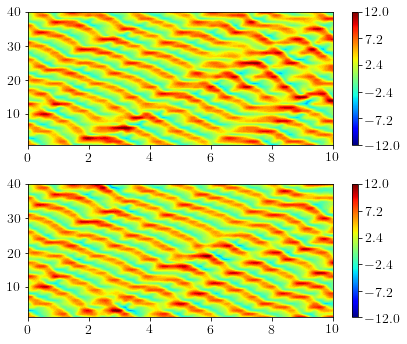

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 28 22:15:00 2020

@author: suraj
"""

import numpy as np
from numpy.random import seed
seed(22)
from scipy import integrate
from scipy import linalg
import matplotlib.pyplot as plt 
import time as tm
import matplotlib.ticker as ticker
import random

font = {'family' : 'Times New Roman',
        'size'   : 14}    
plt.rc('font', **font)

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

#%%
def rhs(ne,u,fr):
    v = np.zeros(ne+3)
    v[2:ne+2] = u
    v[1] = v[ne+1]
    v[0] = v[ne]
    v[ne+2] = v[2]
    random = np.random.normal(0,1,ne+3)
    ek = 0.2393*np.ones(ne+3)*random
    r = np.zeros(ne)
    
#    for i in range(2,ne+2):
#        r[i-2] = v[i-1]*(v[i+1] - v[i-2]) - v[i] + fr
    
    r = v[1:ne+1]*(v[3:ne+3] - v[0:ne]) - v[2:ne+2] - 0.03779 - 0.47362*v[2:ne+2] + 0.005197*v[2:ne+2]**2 + 0.004882*v[2:ne+2]**3 - 0.0003142*v[2:ne+2]**4 + fr + 0.9453*ek[2:ne+2] + 0.2265*random[2:ne+2]
    
    return r
    
    
def rk4(ne,dt,u,fr):
    r1 = rhs(ne,u,fr)
    k1 = dt*r1
    
    r2 = rhs(ne,u+0.5*k1,fr)
    k2 = dt*r2
    
    r3 = rhs(ne,u+0.5*k2,fr)
    k3 = dt*r3
    
    r4 = rhs(ne,u+k3,fr)
    k4 = dt*r4
    
    un = u + (k1 + 2.0*(k2 + k3) + k4)/6.0
    
    return un
       
#%%
ne = 40

dt = 0.001
tmax = 10.0
tini = 15.0
ns = int(tini/dt)
nt = int(tmax/dt)
fr = 10.0
nf = 20         # frequency of observation
nb = int(nt/nf) # number of observation time

u = np.zeros(ne)
utrue = np.zeros((ne,nt+1))
uinit = np.zeros((ne,ns+1))

#-----------------------------------------------------------------------------#
# generate true solution trajectory
#-----------------------------------------------------------------------------#
ti = np.linspace(-tini,0,ns+1)
t = np.linspace(0,tmax,nt+1)
tobs = np.linspace(0,tmax,nb+1)
x = np.linspace(1,ne,ne)

X,T = np.meshgrid(x,t,indexing='ij')
Xi,Ti = np.meshgrid(x,ti,indexing='ij')

data = np.load('data_cyclic.npz')
uclosure_all = data['utrue']

nts = int(10.0/dt)

uclosure = uclosure_all[:,nts:]
utrue[:,0] = uclosure[:,0]

# generate true forward solution
for k in range(1,nt+1):
    u = utrue[:,k-1]
    un = rk4(ne,dt,u,fr)
    utrue[:,k] = un

#%%    
#fort = np.loadtxt('true_trajectory.plt',skiprows=1)
#u1p = utrue[19,:]
#u1f = fort[500:,2]
#aa = u1p - u1f
#
#field = np.loadtxt('true_field.plt',skiprows=2) 
#ufort = field[:,2].reshape(ns+nt+1,ne,order='f')
#
#ufort_i = ufort[:501,:].T
#ufort_e = ufort[500:,:].T
#
#aa = utrue - ufort_e

#%%
vmin = -12
vmax = 12
fig, ax = plt.subplots(2,1,figsize=(6,5))
cs = ax[0].contourf(T,X,uclosure,40,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(uinit)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))

#cs = ax[1].contourf(T,X,ufort_e,cmap='jet',vmin=-vmin,vmax=vmax)
#m = plt.cm.ScalarMappable(cmap='jet')
#m.set_array(uinit)
#m.set_clim(vmin, vmax)
#fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))

cs = ax[1].contourf(T,X,utrue,40,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(utrue)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))

fig.tight_layout()
plt.show()

#%%
#-----------------------------------------------------------------------------#
# generate observations
#-----------------------------------------------------------------------------#
mean = 0.0
sd2 = 1.0e0 # added noise (variance)
sd1 = np.sqrt(sd2) # added noise (standard deviation)

oib = [nf*k for k in range(nb+1)]

uobs = uclosure[:,oib] + np.random.normal(mean,sd1,[ne,nb+1])

#-----------------------------------------------------------------------------#
# generate erroneous soltions trajectory
#-----------------------------------------------------------------------------#
uw = np.zeros((ne,nt+1))
k = 0
si2 = 1.0e-2
si1 = np.sqrt(si2)

u = utrue[:,0] + np.random.normal(mean,si1,ne)
uw[:,0] = u

for k in range(1,nt+1):
    un = rk4(ne,dt,u,fr)
    uw[:,k] = un
    u = np.copy(un)

#%%
#-----------------------------------------------------------------------------#
# EnKF model
#-----------------------------------------------------------------------------#    

# number of observation vector
me = 40

freq = int(ne/me)
oin = [freq*i-1 for i in range(1,me+1)]
roin = np.int32(np.linspace(0,me-1,me))
print(oin)

#freq = int(ne/me)
#oin = sorted(random.sample(range(ne), me)) #[freq*i-1 for i in range(1,me+1)]
#roin = np.int32(np.linspace(0,me-1,me))
#print(oin)

dh = np.zeros((me,ne))
dh[roin,oin] = 1.0

H = np.zeros((me,ne))
H[roin,oin] = 1.0

#%%
# number of ensemble 
file = open("error.txt", "a", buffering=1)
npe_list = [20]
lambd_list = [1.01]

for npe in npe_list:
    for lambd in lambd_list:
        cn = 1.0/np.sqrt(npe-1)
        z = np.zeros((me,nb+1))
        zf = np.zeros((me,npe,nb+1))
        DhX = np.zeros((me,npe))
        DhXm = np.zeros(me)
        
        ua = np.zeros((ne,nt+1)) # mean analyssi solution (to store)
        uf = np.zeros(ne)        # mean forecast
        sc = np.zeros((ne,npe))   # square-root of the covariance matrix
        Af = np.zeros((ne,npe))   # Af data
        ue = np.zeros((ne,npe,nt+1)) # all ensambles
        ph = np.zeros((ne,me))
        
        km = np.zeros((ne,me))
        kmd = np.zeros((ne,npe))
        
        cc = np.zeros((me,me))
        ci = np.zeros((me,me))
        
        for k in range(nb+1):
            z[:,k] = uobs[oin,k]
            for n in range(npe):
                zf[:,n,k] = z[:,k] + np.random.normal(mean,sd1,me)
        
        #%%
        # initial ensemble
        k = 0
        se2 = 0.0 #np.sqrt(sd2)
        se1 = np.sqrt(se2)
        
        for n in range(npe):
            ue[:,n,k] = uw[:,k] + np.random.normal(mean,si1,ne)       
            
        ua[:,k] = np.sum(ue[:,:,k],axis=1)
        ua[:,k] = ua[:,k]/npe
        
        kobs = 1
        
        # RK4 scheme
        for k in range(1,nt+1):
            
            # forecast afor all ensemble fields
            for n in range(npe):
                u[:] = ue[:,n,k-1]
                un = rk4(ne,dt,u,fr)
                ue[:,n,k] = un[:] + np.random.normal(mean,se1,ne)
            
            # mean analysis for plotting
            ua[:,k] = np.sum(ue[:,:,k],axis=1)
            ua[:,k] = ua[:,k]/npe
            
            if k == oib[kobs]:
                # compute mean of the forecast fields
                uf[:] = np.sum(ue[:,:,k],axis=1)   
                uf[:] = uf[:]/npe
                
                # compute square-root of the covariance matrix
                for n in range(npe):
                    sc[:,n] = cn*(ue[:,n,k] - uf[:])
                
                # compute DhXm data
                DhXm[:] = np.sum(ue[oin,:,k],axis=1)    
                DhXm[:] = DhXm[:]/npe
                
                # compute DhM data
                for n in range(npe):
                    DhX[:,n] = cn*(ue[oin,n,k] - DhXm[:])
                    
                # R = sd2*I, observation m+atrix
                cc = DhX @ DhX.T
                
                for i in range(me):
                    cc[i,i] = cc[i,i] + sd2
                
                ph = sc @ DhX.T
                            
                ci = np.linalg.pinv(cc) # ci: inverse of cc matrix
                
                km = ph @ ci
                
                # analysis update    
                kmd = km @ (zf[:,:,kobs] - ue[oin,:,k])
                ue[:,:,k] = ue[:,:,k] + kmd[:,:]
                
                # mean analysis for plotting
                ua[:,k] = np.sum(ue[:,:,k],axis=1)
                ua[:,k] = ua[:,k]/npe
                
                #multiplicative inflation (optional): set lambda=1.0 for no inflation
                ue[:,:,k] = ua[:,k].reshape(-1,1) + lambd*(ue[:,:,k] - ua[:,k].reshape(-1,1))
                
                kobs = kobs+1
        
        np.savez('data_'+str(npe)+'_'+str(lambd)+'.npz',t=t,tobs=tobs,T=T,X=X,utrue=utrue,uobs=uobs,uw=uw,ua=ua,oin=oin)
            
        #%%
        

# Plotting truth, observation and filtering predictions for first 3 components

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


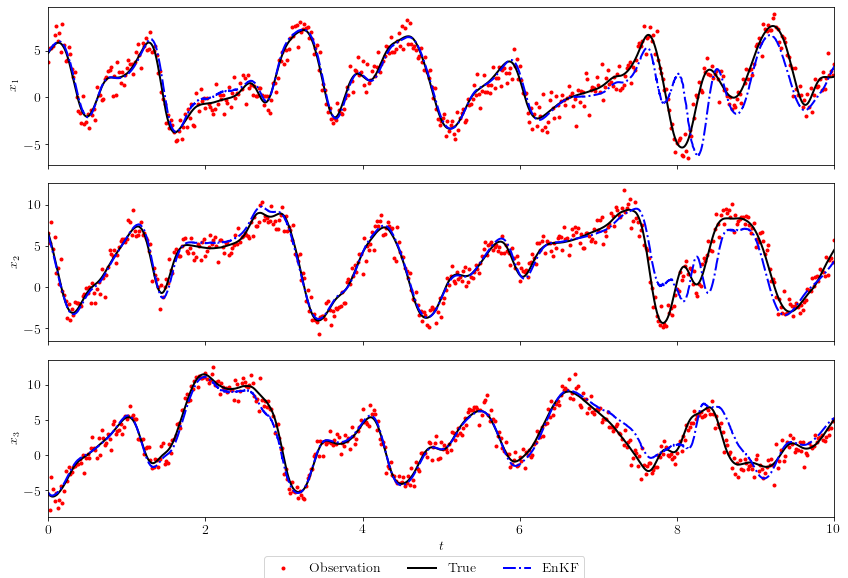

In [6]:
        fig, ax = plt.subplots(3,1,sharex=True,figsize=(12,8))
        n = [0,1,2]
        for i in range(3):
            #if i == 0:
            ax[i].plot(tobs,uobs[n[i],:],'ro',fillstyle='none', markersize=2,markeredgewidth=2)
                
        #    ax[i].plot(t,utrue[n[i],:],'k-')
            ax[i].plot(t,uclosure[n[i],:],'k-', linewidth=2)
            #ax[i].plot(t,uw[n[i],:],'b--')
            ax[i].plot(t,ua[n[i],:],'b-.', linewidth=2)
            
        
            ax[i].set_xlim([0,tmax])
            ax[i].set_ylabel(r'$x_{'+str(n[i]+1)+'}$')
        
        ax[i].set_xlabel(r'$t$')
        line_labels = ['Observation','True','EnKF']
        #line_labels = ['Observation','True','Wrong','EnKF']
        plt.figlegend( line_labels,  loc = 'lower center', borderaxespad=-0.2, ncol=4, labelspacing=0.)
        fig.tight_layout()
        plt.show() 
        fig.savefig('m_'+str(npe)+'_'+str(lambd)+'.png')

# Plotting truth, observation and filtering predictions for first all 40 components

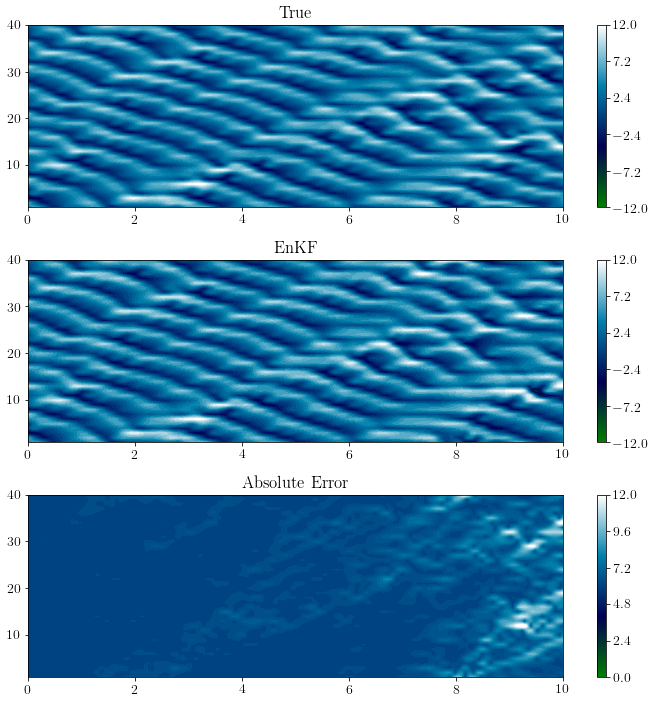

20 1.01 1.5491714607319438


In [7]:
        vmin = -12
        vmax = 12
        fig, ax = plt.subplots(3,1,figsize=(10,10))
        
        cs = ax[0].contourf(T,X,uclosure,30,cmap='ocean',vmin=vmin,vmax=vmax)
        m = plt.cm.ScalarMappable(cmap='ocean')
        m.set_array(utrue)
        m.set_clim(vmin, vmax)
        fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))
        ax[0].set_title('True')
        
        cs = ax[1].contourf(T,X,ua,30,cmap='ocean',vmin=vmin,vmax=vmax)
        m = plt.cm.ScalarMappable(cmap='ocean')
        m.set_array(ua)
        m.set_clim(vmin, vmax)
        fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))
        ax[1].set_title('EnKF')
        
        diff = abs(ua - uclosure)
        cs = ax[2].contourf(T,X,diff,30,cmap='ocean',vmin=vmin,vmax=vmax)
        m = plt.cm.ScalarMappable(cmap='ocean')
        m.set_array(ua)
        m.set_clim(0, vmax)
        fig.colorbar(m,ax=ax[2],ticks=np.linspace(0, vmax, 6))
        ax[2].set_title('Absolute Error')
        
        fig.tight_layout()
        plt.show() 
        fig.savefig('fc_'+str(npe)+'_'+str(lambd)+'.png',dpi=300)   
                
        print(npe, lambd, np.linalg.norm(diff)/np.sqrt(diff.shape[0]*diff.shape[1]))
        print(npe, lambd, np.linalg.norm(diff)/np.sqrt(diff.shape[0]*diff.shape[1]), file=file)

# Calculating Mean Squared Prediction Error

In [8]:
from sklearn.metrics import mean_squared_error

In [9]:
def APSE(X1,X2):
    """
    Calculates the Mean Squared Prediction Error (MSPE) between two time series
 
    Parameters
    ----------
    X1 : 2D ndrray
        Theoretical time series.
    X2 : 2D ndarray
        Predicted time series.
 
    Returns
    -------
    TYPE
        DESCRIPTION.
 
    """
    K = 40
    total_mse = np.array([])
    for i in range(K):
          ss_res = mean_squared_error(X1[:, i], X2[:, i])
          total_mse = np.append(total_mse, ss_res)
    return np.mean(total_mse)

In [10]:
np.shape(uclosure)

(40, 10001)

In [11]:
np.shape(ua)

(40, 10001)

In [12]:
APSE(uclosure,ua)

0.009403099432589618